In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

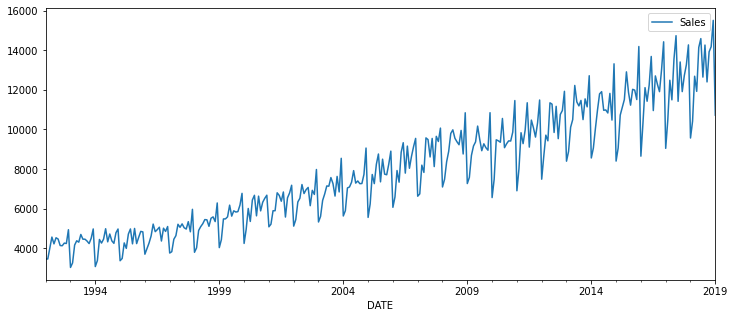

In [5]:
df.plot(figsize=(12,5))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
results = seasonal_decompose(df['Sales'])

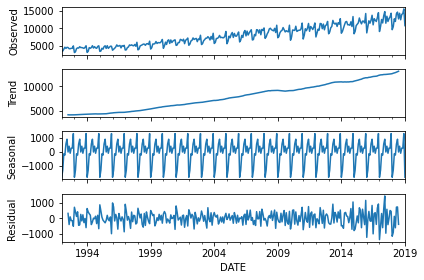

In [9]:
results.plot();

In [10]:
train = df.iloc[:313]
test = df.iloc[313:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [23]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0177
Epoch 2/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0105
Epoch 3/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0089
Epoch 4/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0093
Epoch 5/25
301/301 [==============================] - 6s 21ms/step - loss: 0.0073
Epoch 6/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0059
Epoch 7/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0041
Epoch 8/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0042
Epoch 9/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0027
Epoch 10/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0031
Epoch 11/25
301/301 [==============================] - 6s 21ms/step - loss: 0.0022
Epoch 12/25
301/301 

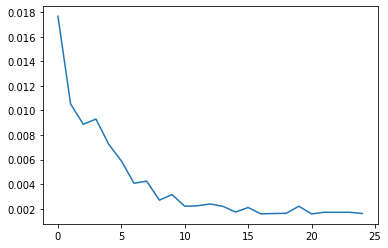

In [25]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [26]:
first_eval_batch = scaled_train[-12:]

In [29]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [30]:
model.predict(first_eval_batch)

array([[0.654602]], dtype=float32)

In [33]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


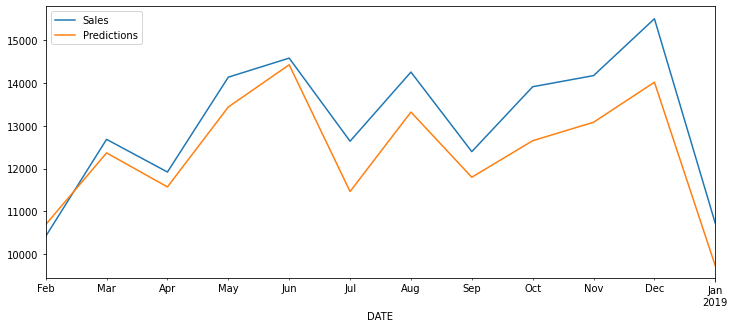

In [36]:
test.plot(figsize=(12,5))